<a href="https://colab.research.google.com/github/lokesharma-dev/Fake-News-Detection/blob/master/VAT_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import 

In [0]:
import numpy as np
import pandas as pd
import re
import spacy
spacy.load('en_core_web_sm')
import random
import time
#------------------- Text preprocessing
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#------------------- Tensorflow
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional

# Text Preprocessing

### Class Spacy

In [0]:
class Spacy(object):

    def __init__(self):
        # python -m spacy download en_core_web_lg
        self.nlp = spacy.load("en_core_web_sm")
        pass

    def deNoise(self, text):
        text = re.sub(r'[“”""]', '', text) # removes quotes
        text = text.replace("'s", '')
        text = re.sub(r'[-]', ' ', text) # helps in splitting doc into sentences
        text = re.sub(r'http[\w:/\.]+', '', text) # removing urls
        text = re.sub(r'[^\.\w\s]', '', text) # removing everything but characters and punctuation
        text = re.sub(r'\.', '.', text) # replace periods with a single one
        text = re.sub(r'\n', ' ', text) # removing line break
        text = re.sub(r'[^\w\s]', '', text.lower())
        text = re.sub(r'\s\s+', ' ', text)  # replace multiple whitespace with one
        return text

    def stopWords(self, text):
        tokens = ""
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
        text = text.split(" ")
        for word in text:
            if word not in spacy_stopwords:
                tokens = tokens + " " + word
        return tokens

    def lemmatize(self, tokens):
        lemma_token = ""
        tokens_object = self.nlp(tokens)
        # lemma_token = [token.lemma_ for token in tokens_object]
        # lemma_token = ''.join(lemma_token) # converts list to string
        for token in tokens_object:
            lemma_token = lemma_token + " " + token.lemma_
        lemma_token = re.sub(r'\s\s+', ' ', lemma_token)  # replace multiple whitespace with one
        lemma_token = lemma_token.strip() # removes trailing whitespaces
        return  lemma_token

    def set_custom_boundaries(self, doc):
        for token in doc[:-1]:
            if token.text == '--':
                doc[token.i+1].is_sent_start = True
        return doc

    def sentence_detect(self, text):
        self.nlp.add_pipe(self.set_custom_boundaries, before='parser')
        doc = self.nlp(text)
        sentences = list(doc.sents)
        for sentence in sentences:
            print(sentence)

    def tokenize(self, text):
        doc = self.nlp(text)
        print([token.text for token in doc])

    def orchestrate(self, text):
        return self.lemmatize(self.stopWords(self.deNoise(text)))

### Class Embedding

In [0]:
class Embedding(object):

    def __init__(self):
        # Parameters
        self.MAX_VOCAB_SIZE = 1000000  # maximum no of unique words
        self.MAX_DOC_LENGTH = 500  # maximum no of words in each sentence
        self.EMBEDDING_DIM = 300  # Embeddings dimension from Glove directory
        self.GLOVE_DIR = '/content/drive/My Drive/Colab Notebooks/glove/glove.6B.' + str(self.EMBEDDING_DIM) + 'd.txt'

    def tokenize_padding(self, docs):
        # Tokenize & pad sequences
        tokenizer = Tokenizer(num_words=self.MAX_VOCAB_SIZE, oov_token='-EOS-')
        tokenizer.fit_on_texts(docs)
        encoded_docs = tokenizer.texts_to_sequences(docs)
        word_index = tokenizer.word_index
        print('Vocabulary size :', len(word_index))
        sequences = pad_sequences(encoded_docs, padding='post', maxlen=self.MAX_DOC_LENGTH)
        return [word_index, sequences]

    def load_glove(self):
        embeddings_index = {}
        f = open(self.GLOVE_DIR, encoding='utf-8')
        print('Loading Glove from: ', self.GLOVE_DIR, '...', end='')
        for line in f:
            values = line.split()
            word = values[0]
            embeddings_index[word] = np.asarray(values[1:], dtype='float32')
        f.close()
        print('Found %s word vectors.' % len(embeddings_index))
        print('\nDone.\nProcedding with Embedded Matrix...', end='')
        return embeddings_index

    def embedding_matrix(self, word_index, embeddings_index):
        # Create an embedding matrix
        # first create a matrix of zeros, this is our embedding matrix
        embeddings_matrix = np.zeros((len(word_index) + 1, self.EMBEDDING_DIM))
        # embeddings_matrix = np.random.random(((20568),EMBEDDING_DIM))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embeddings_matrix[i] = embedding_vector
            else:
                # doesn't exist, assign a random vector
                embeddings_matrix[i] = np.random.random(self.EMBEDDING_DIM)
        print('\nCompleted')
        return embeddings_matrix

### __main__()

In [0]:
# Load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/celebrityDataset.csv')
# Feature Engineering
df.nunique()
df.isna().sum()
df.Subject.fillna('', inplace=True)

x = df.Subject + " " + df.Content
y = pd.Series([0 if row == 'Fake' else 1 for row in df.Label])  # Series is 1D array but with same dtype

S = Spacy()
start = time.time()
docs = [S.orchestrate(row) for row in x]
end = time.time()
print("Cleaning the document took {} seconds".format(round(end - start)))

E = Embedding()
sequences = E.tokenize_padding(docs)
word_index = sequences[0]
sequences = sequences[1]
print('Shape of data tensor:', sequences.shape)
print('Shape of label tensor', y.shape)

embeddings_index = E.load_glove()
embeddings_matrix = E.embedding_matrix(word_index, embeddings_index)

Cleaning the document took 21 seconds
Vocabulary size : 12186
Shape of data tensor: (500, 500)
Shape of label tensor (500,)
Loading Glove from:  /content/drive/My Drive/Colab Notebooks/glove/glove.6B.300d.txt ...Found 400000 word vectors.

Done.
Procedding with Embedded Matrix...
Completed


# Adversarial Examples

In [0]:
# Shuffle data random before splitting
indices = np.arange(sequences.shape[0])
random.Random(1).shuffle(indices)
data = sequences[indices]
labels = y[indices]

num_test_samples = int(0.2 * data.shape[0])
x_train = data[:-num_test_samples]
y_train = labels[:-num_test_samples]
x_test = data[-num_test_samples:]
y_test = labels[-num_test_samples:]

In [0]:
import numpy as np
from scipy import spatial
len(word_index)
type(embeddings_matrix)
embeddings_matrix.shape

(12187, 300)

### Create noised data for Language based on Synonyms

In [0]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))[0:5]

def replaceTokenFn(tokens):
  query = [key for token in tokens for key, value in word_index.items() if value == token]
  replacement = []
  for token in query:
    try:
      print(token)
      replacement.append(find_closest_embeddings(embeddings_dict[token]))
    except KeyError:
      print(token,"-----")
      replacement.append(token)
  print("=====",replacement)
  replaceTokens = []
  for t, r in zip(tokens, replacement):
      if r[1] in word_index:
        replaceTokens.append(word_index[r[1]])
      elif r[2] in word_index:
        replaceTokens.append(word_index[r[2]])
      else:
        replaceTokens.append(t)
  print("++++", replaceTokens)
  res = {t:r for t, r in zip(query, replaceTokens)} 
  print(res)
  return res

# flag = 1
# for k,v in word_index.items():
#   print(k,v,type(v))
#   flag = flag +1
#   if flag == 10:
#     break

In [0]:
EMBEDDING_DIM = 300
GLOVE_DIR = '/content/drive/My Drive/Colab Notebooks/glove/glove.6B.' + str(EMBEDDING_DIM) + 'd.txt'
f = open(GLOVE_DIR, encoding='utf-8')
embeddings_dict = {}
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

In [0]:
replace_count = 10
indices = []
tokens = []
r_train = []
start = time.time()
for seq in x_train[:2]:
  idx = seq.argsort()[-10:][::-1]
  tokens = list(set(seq[idx]))
  rt = replaceTokenFn(tokens)
  r_train.append([rt.get(item,item) for item in seq])
end = time.time()
print("Noising the document took {} seconds".format(round(end - start)))


welsh
arise
housekeeping
towel
treadmill
zeta
cary
diagnosis
rear
bodywork
===== [['welsh', 'wales', 'scottish', 'scots', 'english'], ['arise', 'arises', 'arising', 'arose', 'arisen'], ['housekeeping', 'em96', '24aou94', 'str95bb', 'js94bb'], ['towel', 'towels', 'cloth', 'wrap', 'wrapped'], ['treadmill', 'stairmaster', 'js03', 'kd97', 'em96'], ['zeta', 'epsilon', 'k978-1', 'kd97', 'k977-1'], ['cary', 'elwes', 'wc2003-sri', 'em96', 'naborsind'], ['diagnosis', 'diagnoses', 'diagnostic', 'prognosis', 'diagnosed'], ['rear', 'front', 'wheel', 'wheels', 'fitted'], ['bodywork', 'chassis', 'fibreglass', 'utilising', 'em96']]
++++ [2853, 5892, 6407, 5288, 4551, 4213, 10554, 10555, 6923, 10557]
{'welsh': 2853, 'arise': 5892, 'housekeeping': 6407, 'towel': 5288, 'treadmill': 4551, 'zeta': 4213, 'cary': 10554, 'diagnosis': 10555, 'rear': 6923, 'bodywork': 10557}
nanny
dentistry
ego
four
freshen
wrinkle
beard
soften
===== [['nanny', 'housekeeper', 'nannies', 'babysitter', 'governess'], ['dentistry'

In [0]:
flag = 1
for k,v in word_index.items():
  print(k,v,type(v))
  flag = flag +1
  if flag == 10:
    break

-EOS- 1 <class 'int'>
not 2 <class 'int'>
pron 3 <class 'int'>
say 4 <class 'int'>
be 5 <class 'int'>
year 6 <class 'int'>
like 7 <class 'int'>
tell 8 <class 'int'>
do 9 <class 'int'>


In [0]:
for i, j in zip(r_train[0], x_train[0]):
  print(i,j)

2465 2465
4213 4213
2466 2466
113 113
184 184
935 935
4 4
23 23
1143 1143
116 116
2465 2465
4213 4213
2466 2466
8 8
463 463
407 407
120 120
487 487
4212 4212
4 4
23 23
1143 1143
116 116
4897 4897
636 636
1711 1711
4 4
3 3
18 18
19 19
101 101
869 869
2683 2683
94 94
1044 1044
13 13
23 23
242 242
1143 1143
593 593
5288 5288
30 30
1023 1023
407 407
5892 5892
8 8
676 676
468 468
6 6
184 184
4 4
102 102
1986 1986
760 760
448 448
18 18
2 2
652 652
1210 1210
6 6
94 94
10 10
39 39
192 192
3286 3286
468 468
105 105
10554 10554
474 474
1033 1033
353 353
2130 2130
1355 1355
736 736
1244 1244
487 487
885 885
10555 10555
877 877
174 174
2517 2517
4 4
67 67
237 237
400 400
205 205
9 9
2 2
47 47
23 23
22 22
3 3
90 90
52 52
77 77
1479 1479
15 15
391 391
205 205
473 473
3 3
5 5
127 127
10556 10556
620 620
1739 1739
2465 2465
83 83
1782 1782
892 892
1400 1400
12 12
446 446
1553 1553
54 54
340 340
3660 3660
878 878
419 419
8 8
30 30
6407 6407
157 157
3 3
5 5
1716 1716
566 566
498 498
42 42
7 7
3 3
5 5
15

In [0]:
test = []
start = time.time()
for seq in x_train[:1]:
  idx = seq.argsort()[-10:][::-1]
  tokens = list(set(seq[idx]))
  rt = replaceTokenFn(tokens)
  test.append([rt.get(item,item) for item in seq])
end = time.time()
print("Noising the document took {} seconds".format(round(end - start)))

welsh
arise
housekeeping
towel
treadmill
zeta
cary
diagnosis
rear
bodywork
===== [['welsh', 'wales', 'scottish', 'scots', 'english'], ['arise', 'arises', 'arising', 'arose', 'arisen'], ['housekeeping', 'em96', '24aou94', 'str95bb', 'js94bb'], ['towel', 'towels', 'cloth', 'wrap', 'wrapped'], ['treadmill', 'stairmaster', 'js03', 'kd97', 'em96'], ['zeta', 'epsilon', 'k978-1', 'kd97', 'k977-1'], ['cary', 'elwes', 'wc2003-sri', 'em96', 'naborsind'], ['diagnosis', 'diagnoses', 'diagnostic', 'prognosis', 'diagnosed'], ['rear', 'front', 'wheel', 'wheels', 'fitted'], ['bodywork', 'chassis', 'fibreglass', 'utilising', 'em96']]
++++ [2853, 5892, 6407, 5288, 4551, 4213, 10554, 10555, 6923, 10557]
{'welsh': 2853, 'arise': 5892, 'housekeeping': 6407, 'towel': 5288, 'treadmill': 4551, 'zeta': 4213, 'cary': 10554, 'diagnosis': 10555, 'rear': 6923, 'bodywork': 10557}
Noising the document took 45 seconds


In [0]:
rt

{'arise': 5892,
 'bodywork': 10557,
 'cary': 10554,
 'diagnosis': 10555,
 'housekeeping': 6407,
 'rear': 6923,
 'towel': 5288,
 'treadmill': 4551,
 'welsh': 2853,
 'zeta': 4213}

In [0]:
for seq in x_train[:1]:
  print(seq)

[ 2465  4213  2466   113   184   935     4    23  1143   116  2465  4213
  2466     8   463   407   120   487  4212     4    23  1143   116  4897
   636  1711     4     3    18    19   101   869  2683    94  1044    13
    23   242  1143   593  5288    30  1023   407  5892     8   676   468
     6   184     4   102  1986   760   448    18     2   652  1210     6
    94    10    39   192  3286   468   105 10554   474  1033   353  2130
  1355   736  1244   487   885 10555   877   174  2517     4    67   237
   400   205     9     2    47    23    22     3    90    52    77  1479
    15   391   205   473     3     5   127 10556   620  1739  2465    83
  1782   892  1400    12   446  1553    54   340  3660   878   419     8
    30  6407   157     3     5  1716   566   498    42     7     3     5
    15   947   762  2850  3632    25     4   236  4551   507   308   978
 10557  1524    33   170  1764   286   827   514  2479    37     0     0
     0     0     0     0     0     0     0     0   

# VAT Variant1

Adding Noise to Embedding's issue of grad returning None is solved.
However, since the concept lies on differenting wrt to inputs (and we specify inputs as tensor shapes and not variables). Please do not consider the evaluaiton results now, as the model is basic and focus is on the right way to introduce perturbations

In [0]:
import numpy as np
import random
import time
#------------------- Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional

MAX_VOCAB_SIZE = 10000 # maximum no of unique words
MAX_DOC_LENGTH = 500 # maximum no of words in each sentence
EMBEDDING_DIM = 300 # Embeddings dimension from Glove directory
def compute_kld(p_logit, q_logit):
  p = tf.nn.softmax(p_logit)
  q = tf.nn.softmax(q_logit)
  kl_score = tf.reduce_sum( p * (tf.math.log(p+1e-16) - tf.math.log(q+1e-16)), axis = 1)
  return kl_score # lower kl means closer the distributions are

In [0]:
inputs = Input(shape=(MAX_DOC_LENGTH,)) 

def createEmbd(inputs):
  return layers.Embedding(input_dim=MAX_VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length = MAX_DOC_LENGTH,
                    trainable=True,
                    mask_zero=True)(inputs)

input_emb = createEmbd(inputs)
noise_emb = tf.random.uniform(shape=tf.shape(input_emb))
noise_emb = tf.math.add(input_emb, noise_emb)

input_h1 = layers.LSTM(units=128,)(input_emb)
noise_h1 = layers.LSTM(units=128,)(noise_emb)

p_logit = layers.Dense(units=16, activation='relu')(input_h1)
p_logit_r = layers.Dense(units=16, activation='relu')(noise_h1)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(noise_emb)
    kl_score = compute_kld(p_logit, p_logit_r)
    kl_score = tf.convert_to_tensor(kl_score, dtype=tf.float32)
grads = tape.gradient(kl_score, noise_emb)

p_logit = tf.stop_gradient(p_logit)
p_logit_r = tf.stop_gradient(p_logit_r)

if grads is None:
  grads = tf.random.uniform(shape=tf.shape(input_emb)) 

vadv_emb = tf.math.add(input_emb, grads)
vadv_h1 = layers.LSTM(units=128,)(vadv_emb)
q_logit = layers.Dense(units=16, activation='relu')(vadv_h1)

vat_loss = compute_kld(p_logit, q_logit)

logits = layers.average([p_logit, p_logit_r, q_logit])
outputs = layers.Dense(units=1, activation='softmax')(logits)
model = keras.Model(inputs, outputs)
model.add_loss(vat_loss)

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss= 'binary_crossentropy',metrics=['accuracy','precision'])
model.fit(x_train, y_train, epochs=2, validation_split=0.2, shuffle=True, batch_size=32)
score, acc = model.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

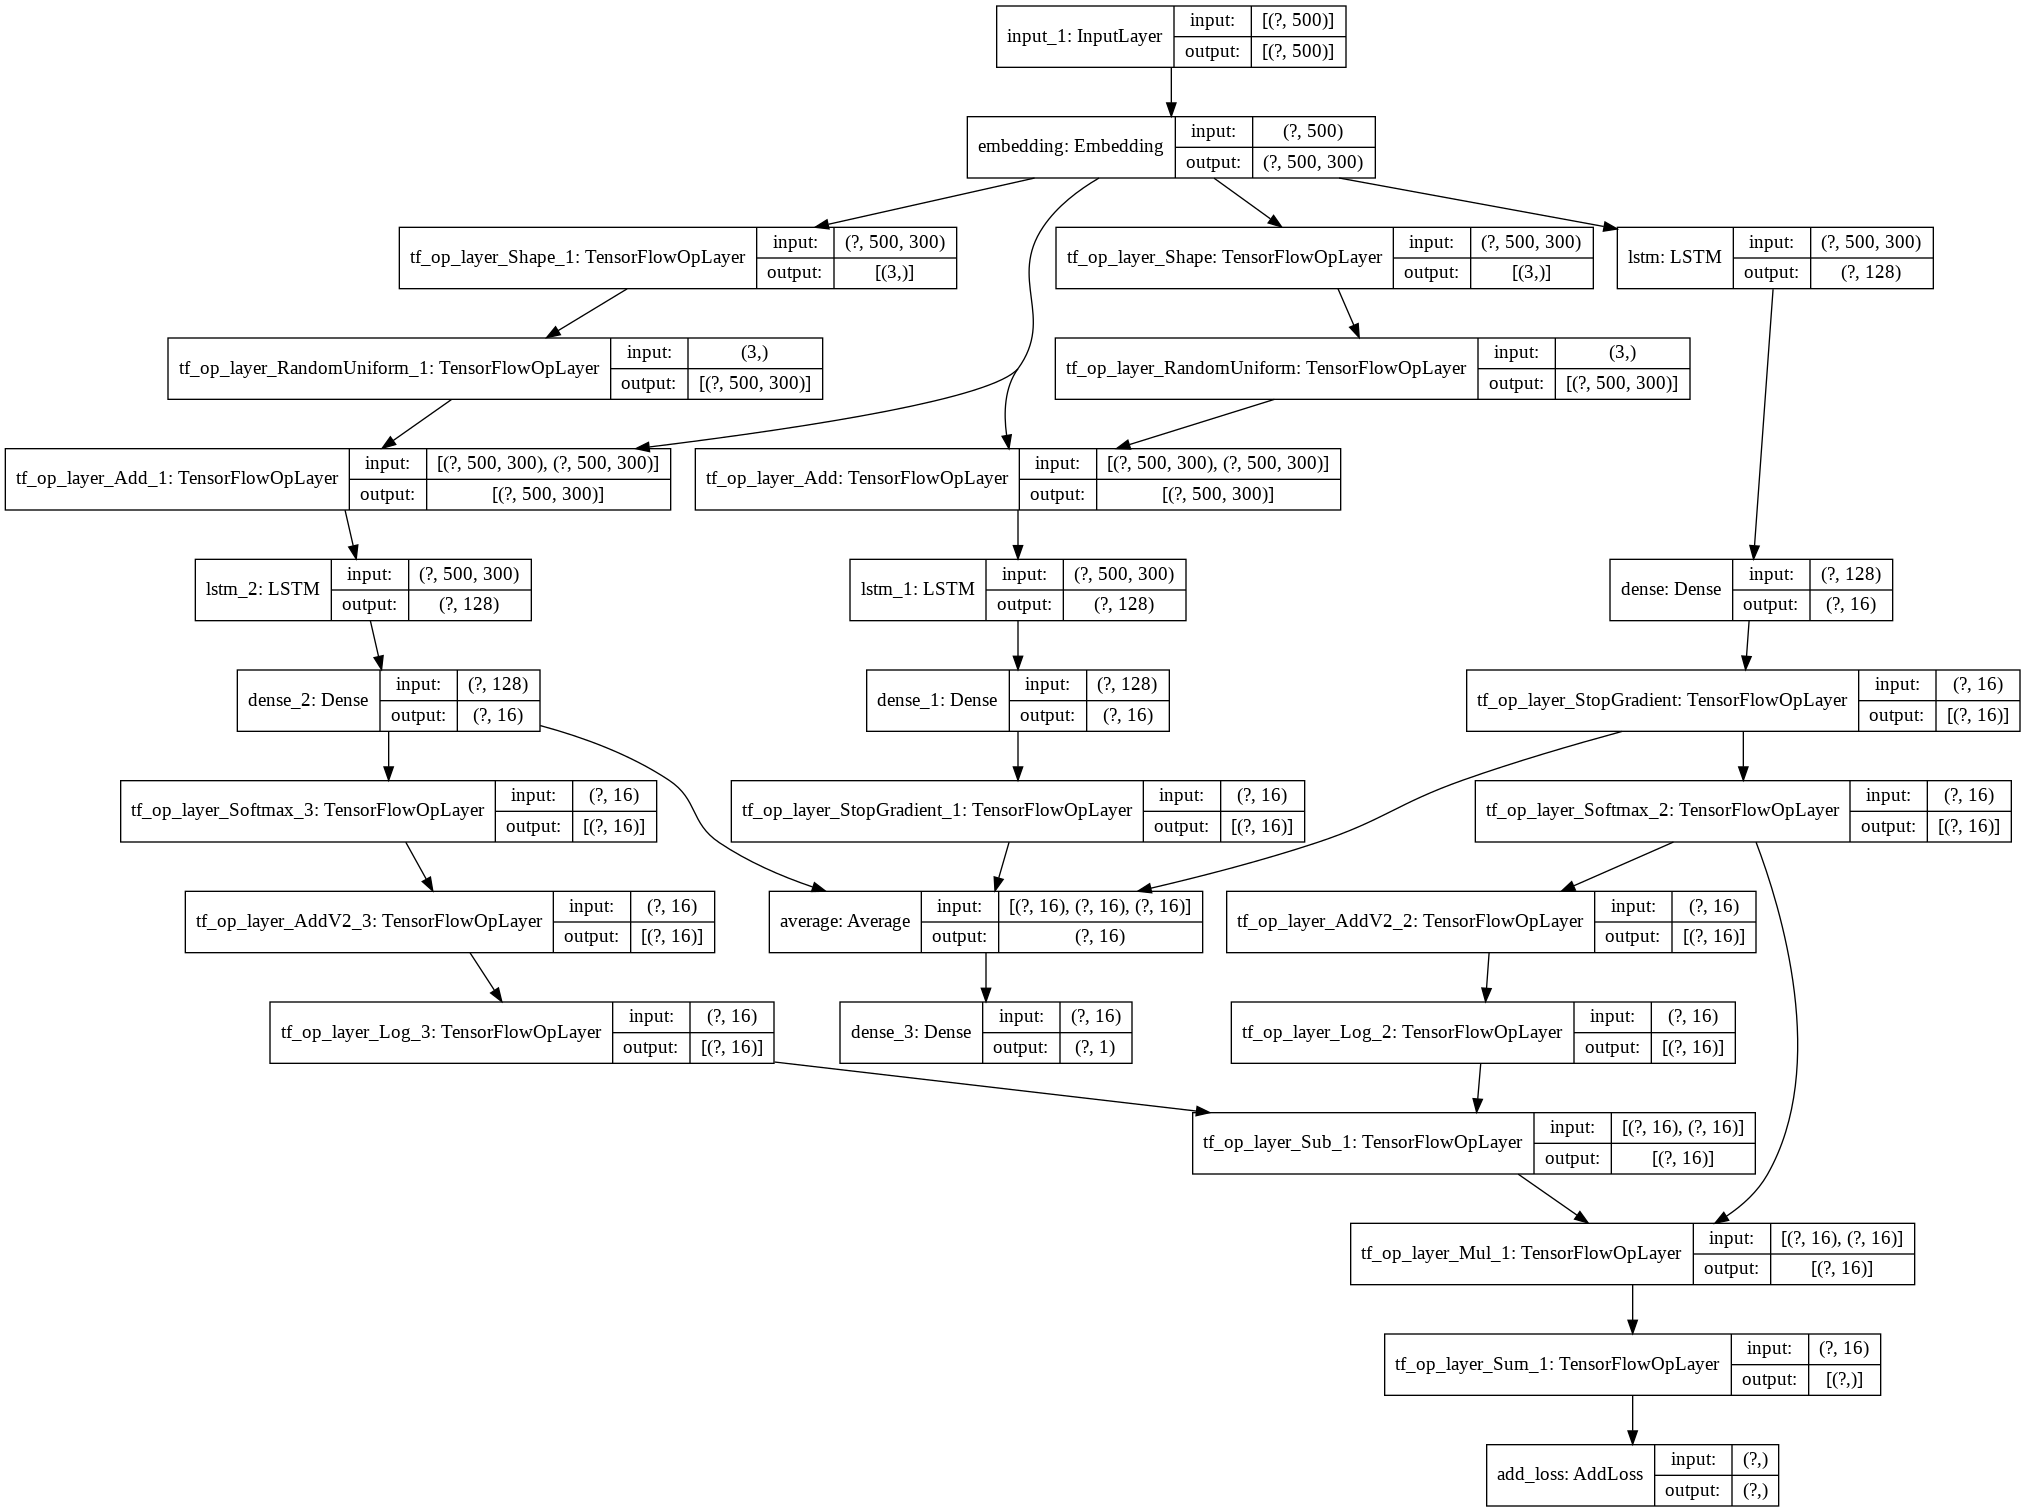

In [0]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# VAT Variant2

Conclusion: Adding perturbations will require Functional API

In [0]:
import numpy as np
import random
import time
#------------------- Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional

MAX_VOCAB_SIZE = 100000 # maximum no of unique words
MAX_DOC_LENGTH = 500 # maximum no of words in each sentence
EMBEDDING_DIM = 300 # Embeddings dimension from Glove directory

In [0]:
def compute_kld(p_logit, q_logit):
  p = tf.nn.softmax(p_logit)
  q = tf.nn.softmax(q_logit)
  kl_score = tf.reduce_sum( p * (tf.math.log(p+1e-16) - tf.math.log(q+1e-16)), axis = 1)
  return kl_score # lower kl means closer the distributions are

def stack_layers(inputs):
  #inputs = keras.Input(shape=(MAX_DOC_LENGTH,)) 
  emb = Embedding(input_dim=MAX_VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length = MAX_DOC_LENGTH,
                    trainable=True,
                    mask_zero=True)(inputs)
  h1 = LSTM(units=128,)(emb)
  outputs = Dense(units=16, activation='relu')(h1)
  return outputs

### Architecture 1

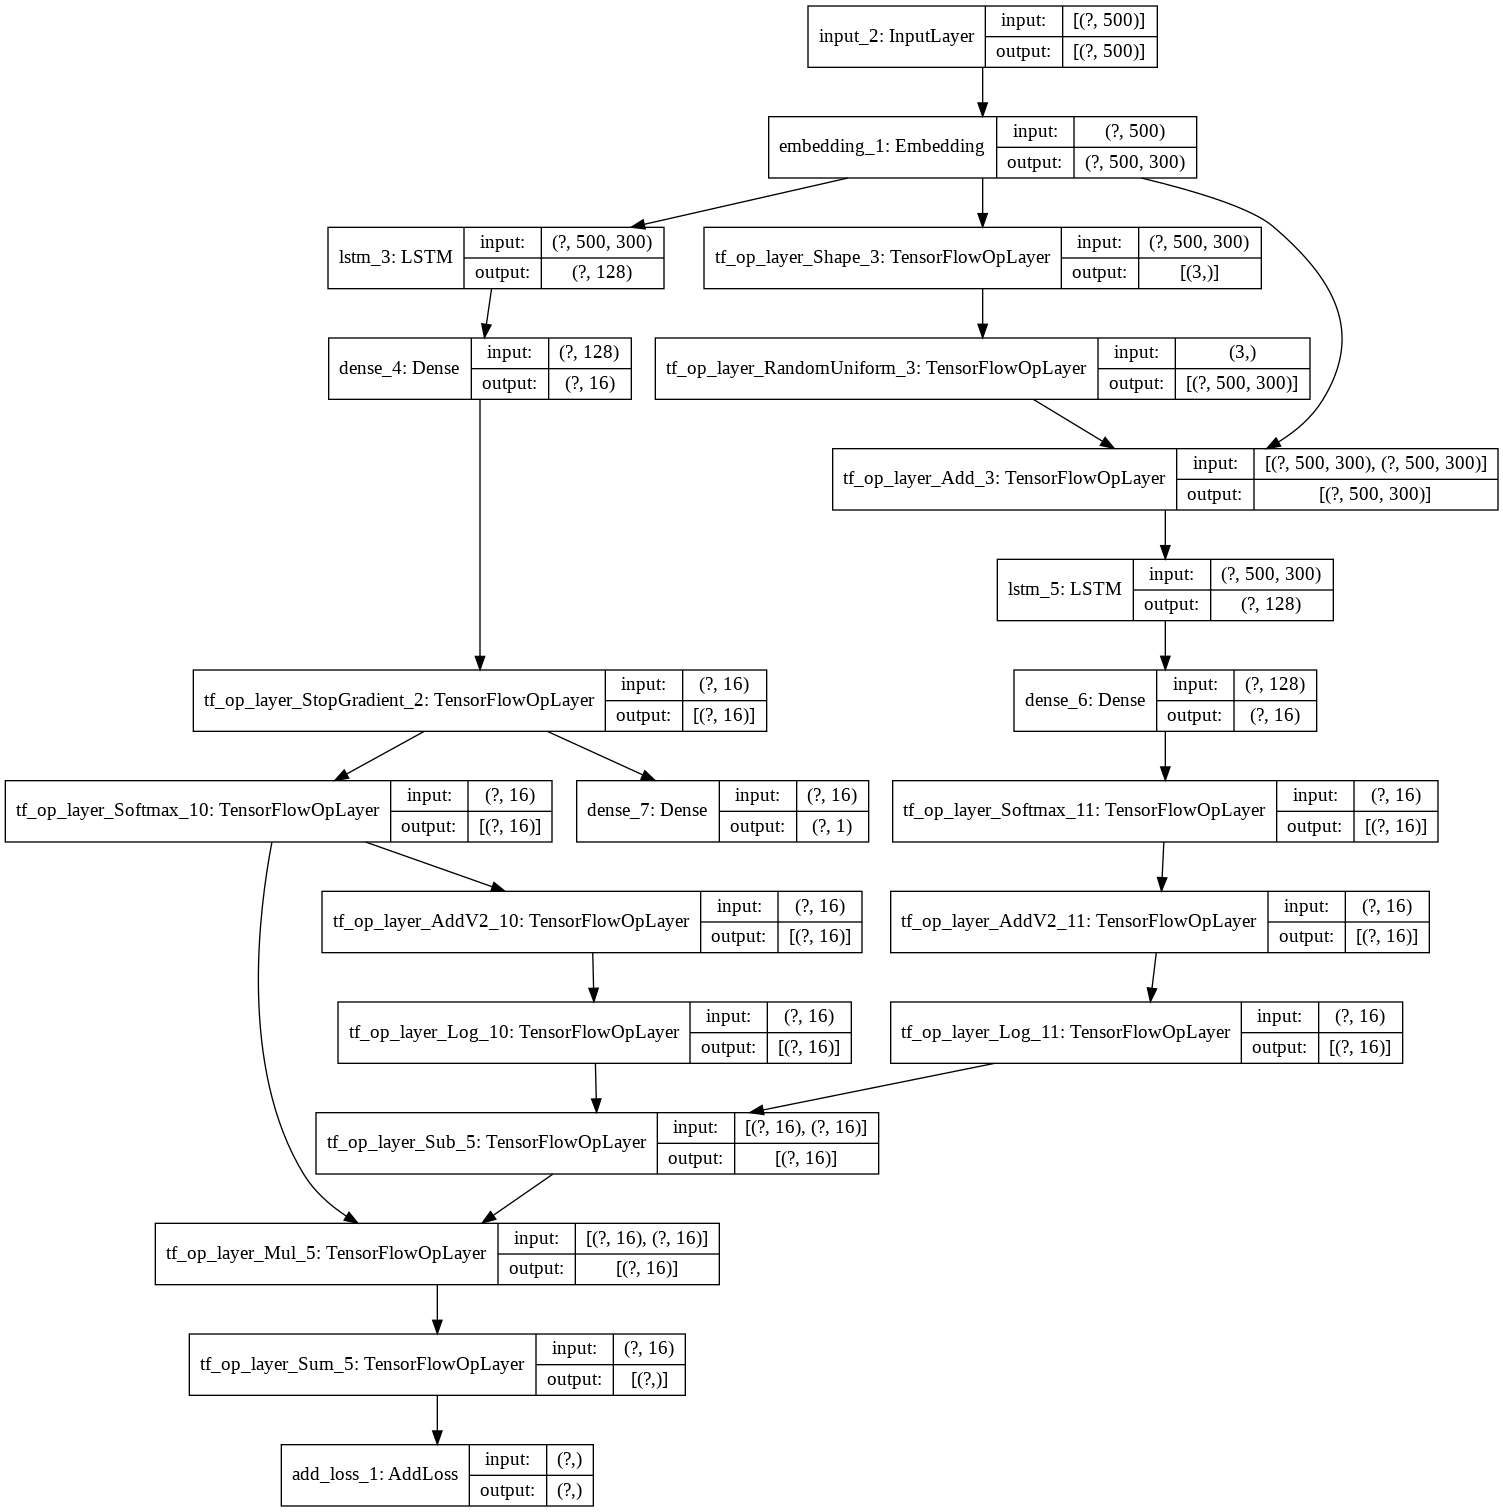

In [0]:
inputs = Input(shape=(MAX_DOC_LENGTH,)) 

def createEmbd(inputs):
  return layers.Embedding(input_dim=MAX_VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length = MAX_DOC_LENGTH,
                    trainable=True,
                    mask_zero=True)(inputs)

input_emb = createEmbd(inputs)
noise_emb = tf.random.uniform(shape=tf.shape(input_emb))
noise_emb = tf.math.add(input_emb, noise_emb)

input_h1 = layers.LSTM(units=128,)(input_emb)
noise_h1 = layers.LSTM(units=128,)(noise_emb)

p_logit = layers.Dense(units=16, activation='relu')(input_h1)
p_logit_r = layers.Dense(units=16, activation='relu')(noise_h1)

kl_score = compute_kld(p_logit, p_logit_r)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(noise_emb)
    kl_score = compute_kld(p_logit, p_logit_r)
    kl_score = tf.convert_to_tensor(kl_score, dtype=tf.float32)
grads = tape.gradient(kl_score, noise_emb)

if grads is None:
  grads = tf.random.uniform(shape=tf.shape(input_emb)) 

p_logit = tf.stop_gradient(p_logit)
p_logit_r = tf.stop_gradient(p_logit_r)


vadv_emb = tf.math.add(input_emb, grads)
vadv_h1 = layers.LSTM(units=128,)(vadv_emb)
q_logit = layers.Dense(units=16, activation='relu')(vadv_h1)
vat_loss = compute_kld(p_logit, q_logit)

p = layers.Dense(units=1, activation='softmax')(p_logit)
vat_loss = compute_kld(p_logit, q_logit)

#model = keras.Model(inputs=inputs, outputs=[p_logit, p_logit_r])
model = keras.Model(inputs=inputs, outputs=p, name="KL_Divergence")
model.add_loss(vat_loss) 
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True )

### Architecture 2

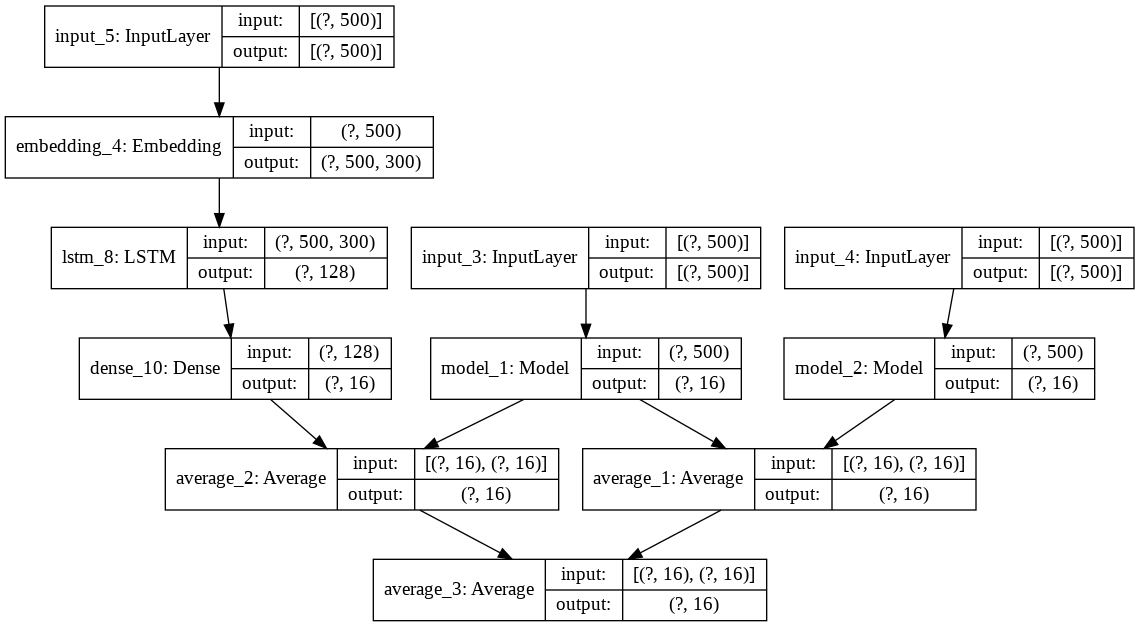

In [0]:
inputs = keras.Input(shape=(MAX_DOC_LENGTH,)) 
noise = keras.Input(shape=(MAX_DOC_LENGTH,)) 
vadv = keras.Input(shape=(MAX_DOC_LENGTH,)) 


def createEmbd(inputs):
  return layers.Embedding(input_dim=MAX_VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length = MAX_DOC_LENGTH,
                    trainable=True,
                    mask_zero=True)(inputs)

input_emb = createEmbd(inputs)
noise_emb = createEmbd(noise)
vadv_embd = createEmbd(vadv)


input_h1 = layers.LSTM(units=128,)(input_emb)
noise_h1 = layers.LSTM(units=128,)(noise_emb)
vadv_h1 = layers.LSTM(units=128,)(vadv_embd)


p_logit = layers.Dense(units=16,)(input_h1)
p_logit_r = layers.Dense(units=16,)(noise_h1)
q_logit = layers.Dense(units=16,)(vadv_h1)

p_logit = tf.stop_gradient(p_logit)
p_logit_r = tf.stop_gradient(p_logit_r)

model1 = Model(inputs, p_logit)
model2 = Model(noise, p_logit_r)

pipe1 = model1(inputs)
pipe2 = model2(noise)

kld1 = layers.average([pipe1, pipe2])
kld2 = layers.average([q_logit, pipe1])
output = layers.average([kld1, kld2])
model = keras.Model(inputs=[inputs, noise, vadv], outputs=output)


keras.utils.plot_model(model, show_shapes=True, show_layer_names=True )

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # only compilation

In [0]:
model.fit(x_train, y_train)

In [0]:
x_train.shape

(400, 500)

In [0]:
#evaluating model
score, acc = model.evaluate(x_test, y_test, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)